In [1]:
#import packages for data (pandas/numpy), optimization (gurobipy), gradient boost(xgbm,lgbm), explainability (shap)
import pandas as pd
import numpy as np
from gurobipy import *
import lightgbm as lgb
import xgboost as xgb
import shap
shap.initjs()


//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#import data for LGBM/XGBM
TrainData = pd.read_excel("P_C_BOP_CleanInsureData.xlsx", sheet_name = "Train_Set", index_col=0)
TestData = pd.read_excel("P_C_BOP_CleanInsureData.xlsx", sheet_name = "Test_Set", index_col=0)


In [3]:
TrainData.head(3)

,Prod_ID,State,Agency_Yr,Agency_Life,Employ_Cnt,Max_Age,Min_Age,Prd_Ernd_Prem,3Yr_LossRatio,Prd_Incrd_Loss,Loss_Ratio
AgencyUID,,,,,,,,,,,
1,BOP,IN,1998,22,56,87,36,570.36,0.285437,0.00,0.00000
2,BOP,IN,1970,50,14,89,32,2842.47,1.215365,0.00,0.00000
3,BOP,IN,1970,50,14,89,32,2868.84,0.438894,1381.46,0.48154


In [4]:
TestData.head(3)

,Prod_ID,State,Agency_Yr,Agency_Life,Employ_Cnt,Max_Age,Min_Age,Prd_Ernd_Prem,3Yr_LossRatio,Prd_Incrd_Loss,Loss_Ratio
AgencyUID,,,,,,,,,,,
4,BOP,IN1,1970,50,14,89,32,2959.69,1.201206,46080.86,15.569489
6,BOP,IN2,1970,50,14,89,32,2535.88,1.344834,0.00,0.000000
8,BOP,IN3,1970,50,14,89,32,1768.91,3.768552,0.00,0.000000


In [5]:
#features defined for Train Set
TrainFeatures=TrainData.loc[:, 'Agency_Life':'3Yr_LossRatio']
#predictor defined for Train Set
TrainOutput=TrainData['Loss_Ratio']
#features defined for Test Set
TestFeatures=TestData.loc[:, 'Agency_Life':'3Yr_LossRatio']
#predictor defined for Test Set
TestOutput=TestData['Loss_Ratio']

In [6]:
Insur_LossRat_Predict = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = .03, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 5)


In [7]:
Insur_LossRat_Predict.fit(TrainFeatures,TrainOutput)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.03, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [8]:
%%time
#make predictions based on model
Predictions = Insur_LossRat_Predict.predict(TestFeatures)

#test for error based on model
TotalError=0
for i in range(len(Predictions)):
    Error = abs(Predictions[i]-TestOutput.iloc[i])
    TotalError = TotalError+Error
Denominator = len(Predictions)
AvgError=TotalError/Denominator
print(round(TotalError,2))
print(round(AvgError,2))


252.76
1.19
CPU times: user 3.82 ms, sys: 1.04 ms, total: 4.87 ms
Wall time: 3.96 ms


In [9]:
explainer = shap.TreeExplainer(Insur_LossRat_Predict)
shap_values = explainer.shap_values(TestFeatures)
print(Predictions[1])
shap.force_plot(explainer.expected_value, shap_values[1,:], TestFeatures.iloc[1,:])

0.7412711


In [10]:
print(Predictions[5])
shap.force_plot(explainer.expected_value, shap_values[5,:], TestFeatures.iloc[5,:])


-0.47435153


In [11]:
#creates optimization model and defines decision variables
mymodel = Model("Climate Optimization Model")
numpredicts = len(Predictions)
decvars = [0]*numpredicts
for i in range(numpredicts): 
     decvars[i] = mymodel.addVar(lb=.8,name="%s_Weight" % TestData.index[i])

Academic license - for non-commercial use only


In [12]:
#this code gets the regional values, computes actuals, and sets the objective of the model
TestRegions=TestData['State']
RegionsMaster = ["IN1","IN2","IN3","IN4","IN5","IN6","IN7","KY1","KY2","KY3","KY4","KY5","KY6","KY7","KY8","KY9","MI1","OH1","OH2","OH3","OH4","OH5","OH6","OH7","OH8","OH9","PA1","PA2","PA3","PA4","WV1","WV2"]
ActualTotalProfit=0
PredictedTotalProfit=0
for Regions in range(len(RegionsMaster)):
    i=0
    ActualRegionProfit=0
    PredictedRegionProfit=0
    for index, value in TestRegions.items():
        if value == RegionsMaster[Regions]:
            ActualThisProfit=Predictions[i]*1*TestData.iloc[i][7] #gets actual value for below (ie, no change or default)
            PredictedThisProfit=Predictions[i]*decvars[i]*TestData.iloc[i][7] #predictedloss x weight x ernd premium = profit
            ActualRegionProfit=ActualRegionProfit+ActualThisProfit
            PredictedRegionProfit=PredictedRegionProfit+PredictedThisProfit
            i=i+1
    ActualTotalProfit=ActualTotalProfit+ActualRegionProfit
    PredictedTotalProfit=PredictedTotalProfit+PredictedRegionProfit
print(ActualTotalProfit)
mymodel.setObjective(PredictedTotalProfit, GRB.MAXIMIZE)

658868.6362822655


In [13]:
#max constraint for weights
maxconstr = [0]*numpredicts
for i in range(numpredicts): 
     maxconstr[i] = mymodel.addConstr(decvars[i]<=1.8,"%s_Weight_Max" % TestData.index[i])

In [14]:
#set up the ground truth list for RegionsCountLimits
RegionsCounter = [0]*len(RegionsMaster)
j=0
for Regions in range(len(RegionsMaster)):
    i=0
    ActualRegionCount=0
    for index, value in TestRegions.items():
        if value == RegionsMaster[Regions]:
            ActualRegionCount=ActualRegionCount+1
            i=i+1
    RegionsCounter[j]=ActualRegionCount
    j=j+1    
print(RegionsCounter)

[6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 3, 12, 12, 12, 12, 11, 9, 9, 9, 9, 6, 3, 3, 3, 5, 5]


In [15]:
#below here has not been tested
RegionsConstraint = [0]*len(RegionsMaster)
h=0
for Regions in range(len(RegionsMaster)):
    f=0
    CheckerRegionCount=0
    for index, value in TestRegions.items():
        if value == RegionsMaster[Regions]:
            #code goes here
            CheckerRegionCount=CheckerRegionCount+decvars[f]
            f=f+1
    RegionsConstraint[h]=CheckerRegionCount
    h=h+1 
    #print(RegionsConstraint)

regionequalconstr = [0]*len(RegionsMaster)
for i in range (len(RegionsMaster)):
    regionequalconstr[i] = mymodel.addConstr(RegionsConstraint[i]<=RegionsCounter[i],"%s_EqualCheck" % TestData.index[i])

In [16]:
mymodel.update()
mymodel
mymodel.optimize()

Optimize a model with 244 rows, 212 columns and 424 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+05]
  Bounds range     [8e-01, 8e-01]
  RHS range        [2e+00, 1e+01]
Presolve removed 241 rows and 205 columns
Presolve time: 0.01s
Presolved: 3 rows, 7 columns, 17 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1857667e+05   2.200000e+00   0.000000e+00      0s
       4    8.2363288e+05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  8.236328799e+05


In [17]:
Improvement =round((mymodel.objVal/ActualTotalProfit)-1,2)*100
print("Optimized Value...%d" % mymodel.objVal)
print("Actual Value......%d" % ActualTotalProfit)
print("Improvement.......%d percent" % Improvement)


Optimized Value...823632
Actual Value......658868
Improvement.......25 percent


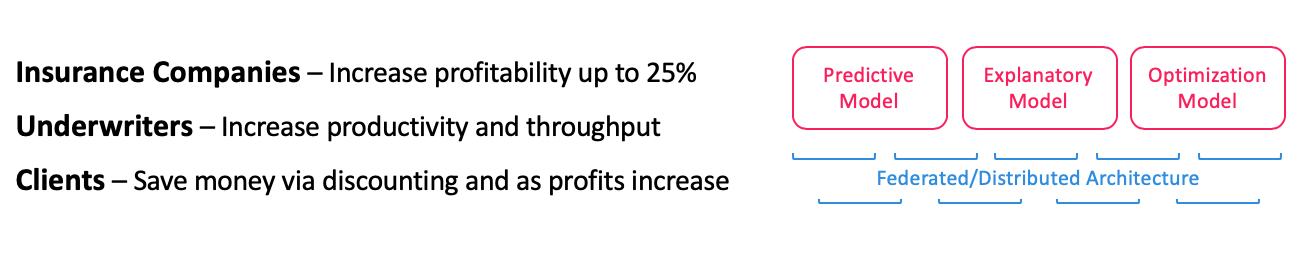

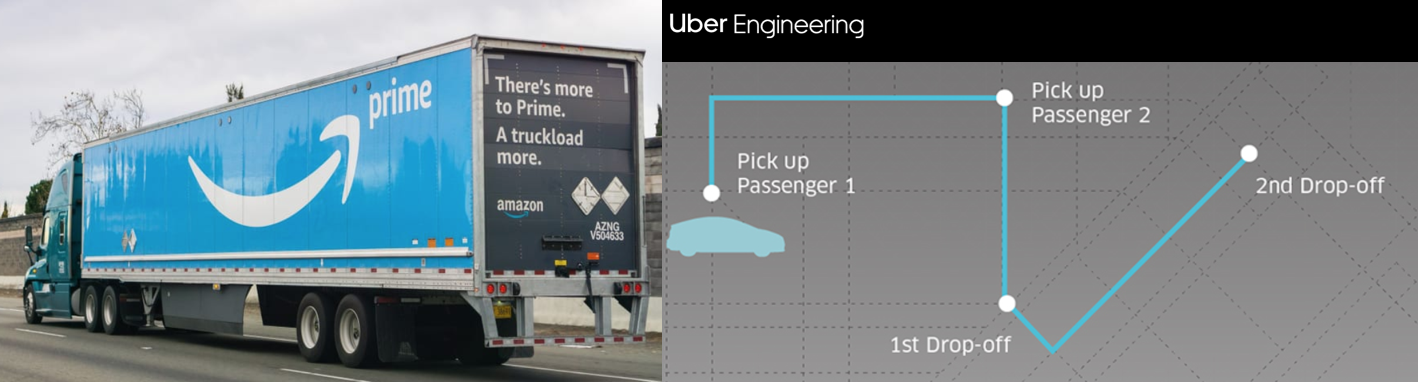

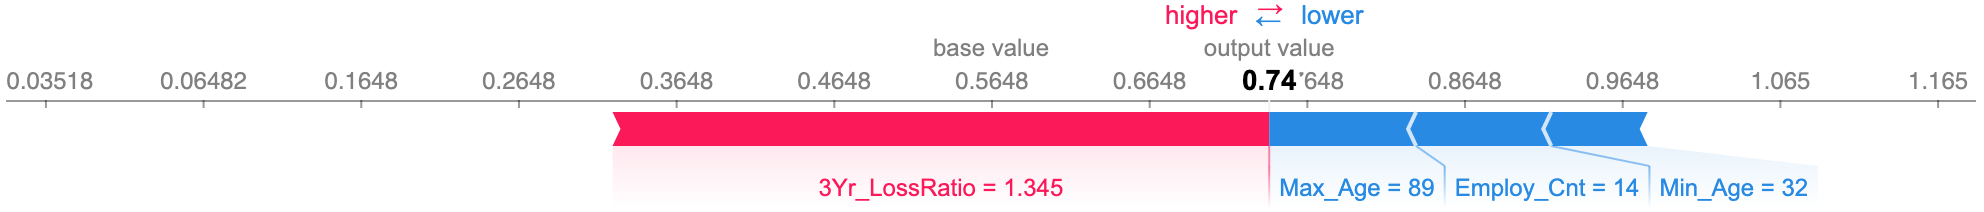

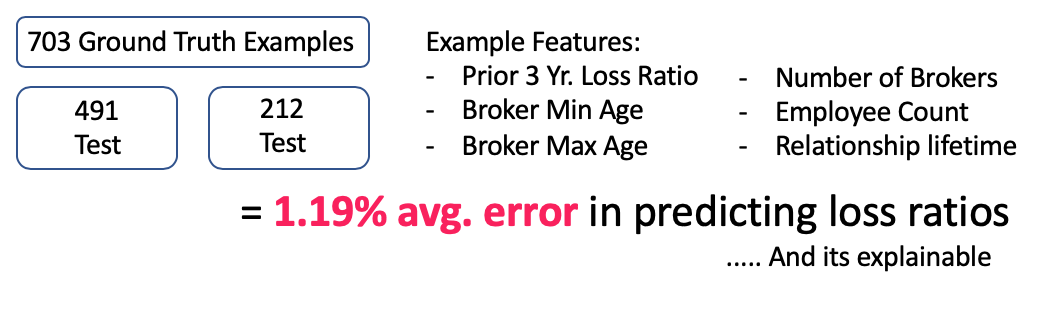

In [18]:
PredModelError = (round(AvgError,2))
print("Predictive Model Error:", PredModelError, "percent")

Predictive Model Error: 1.19 percent


 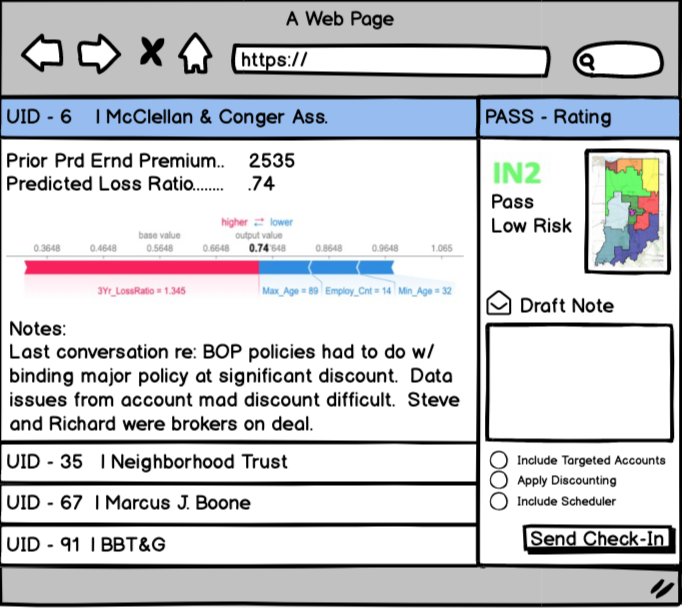

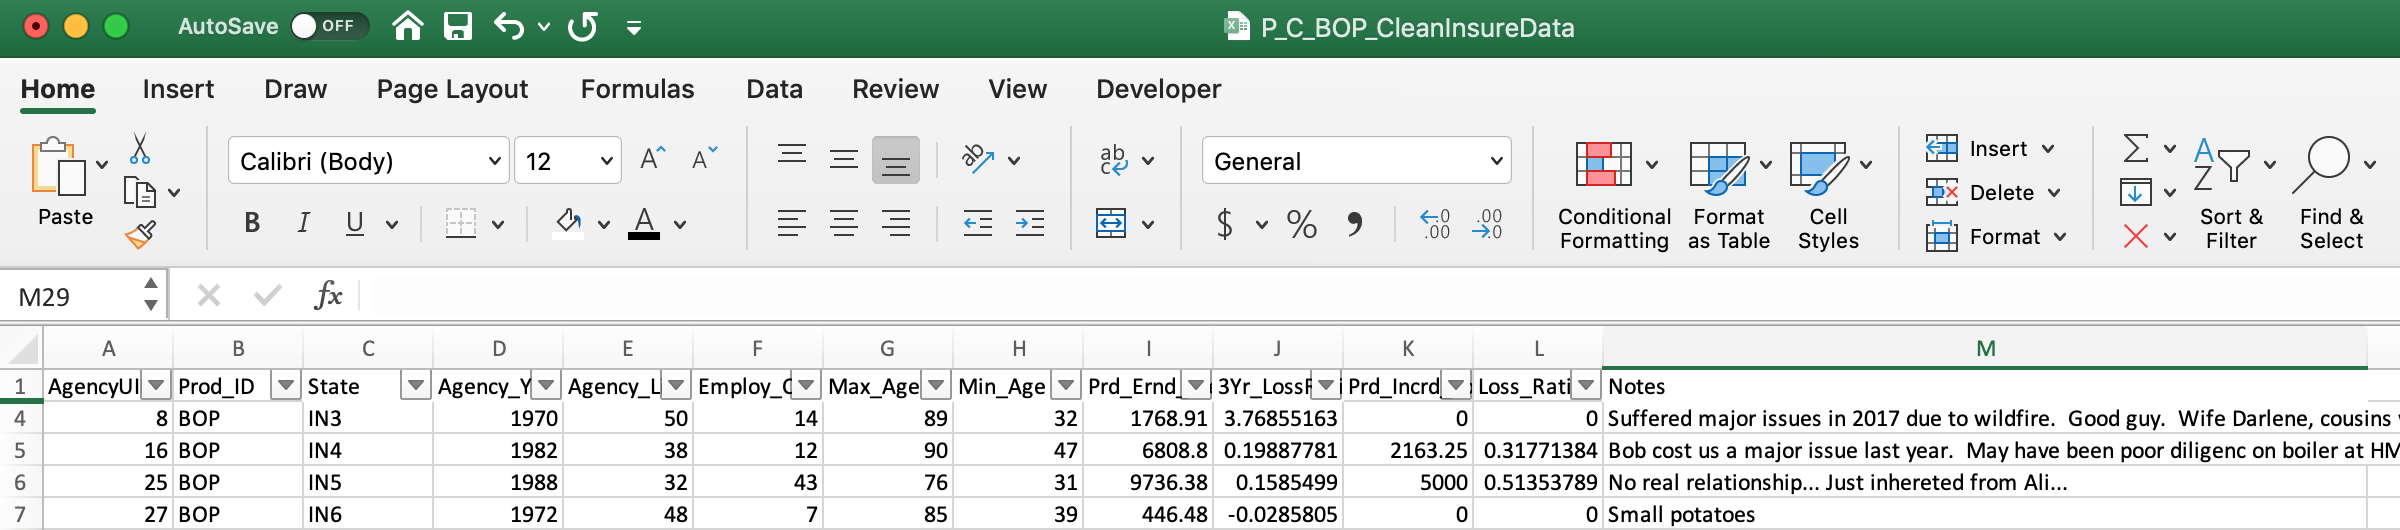

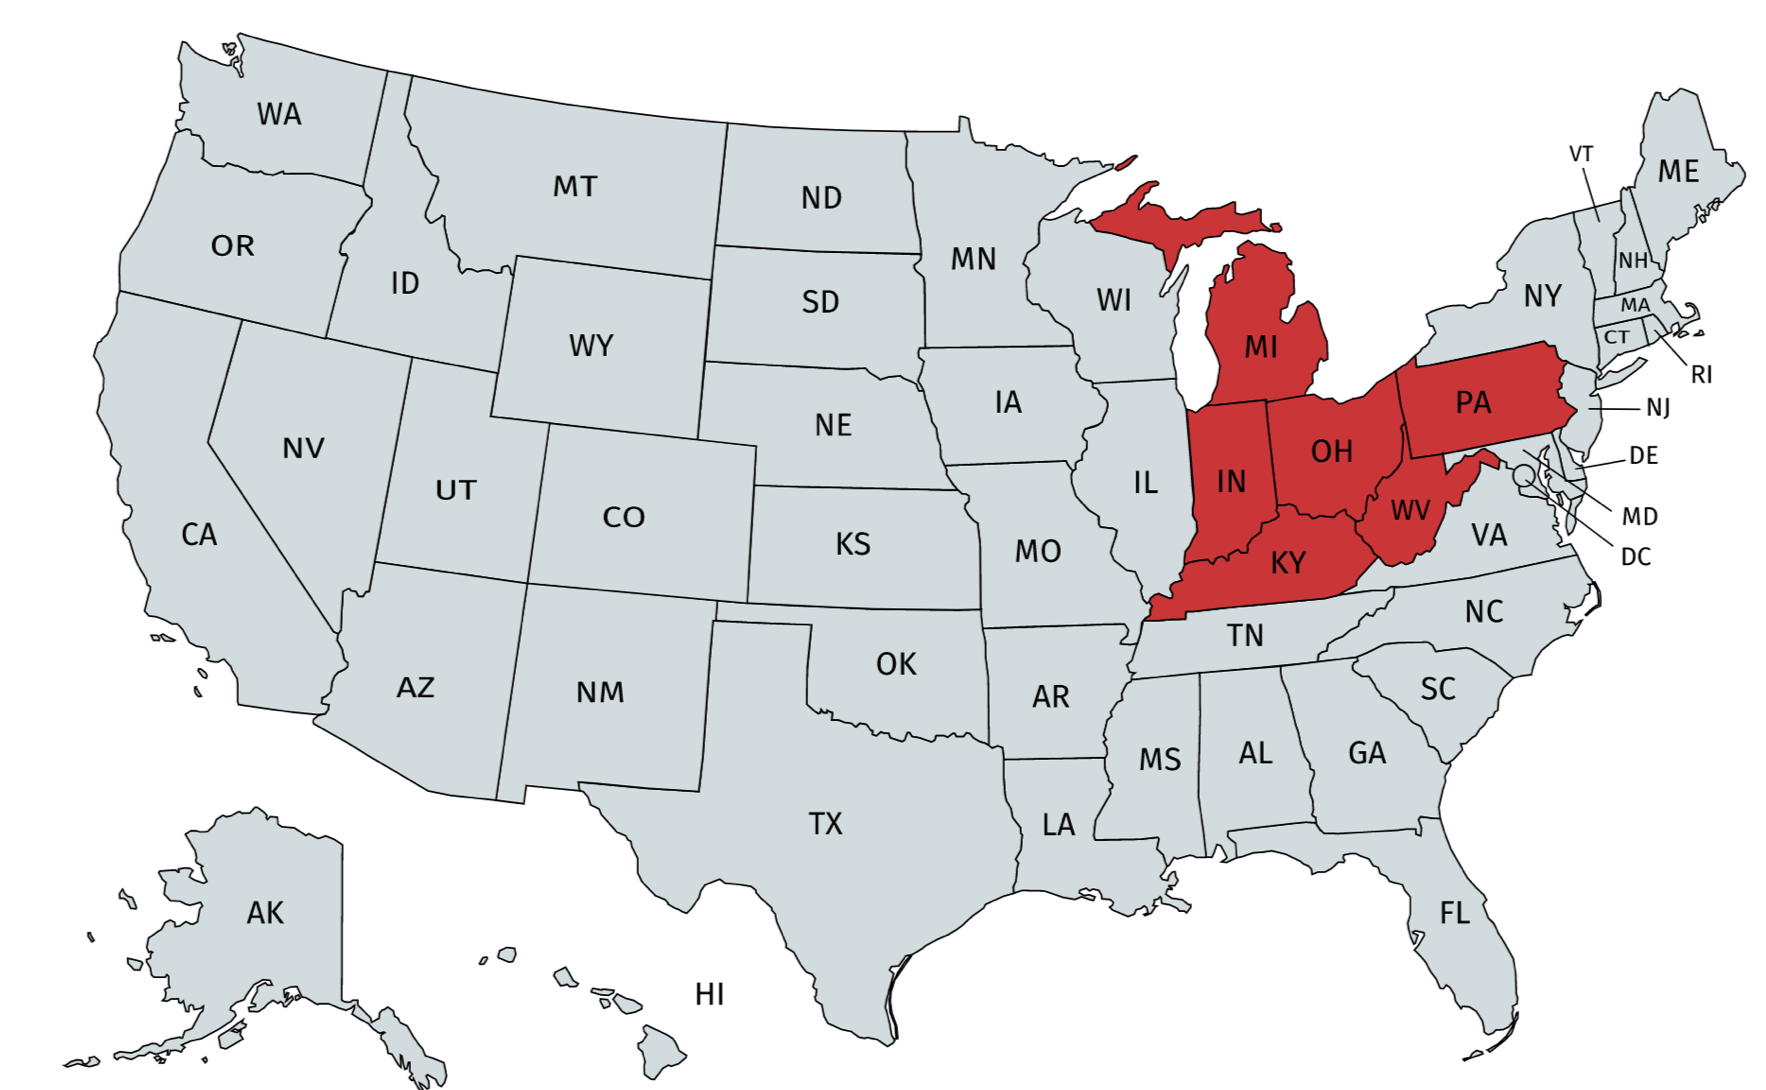

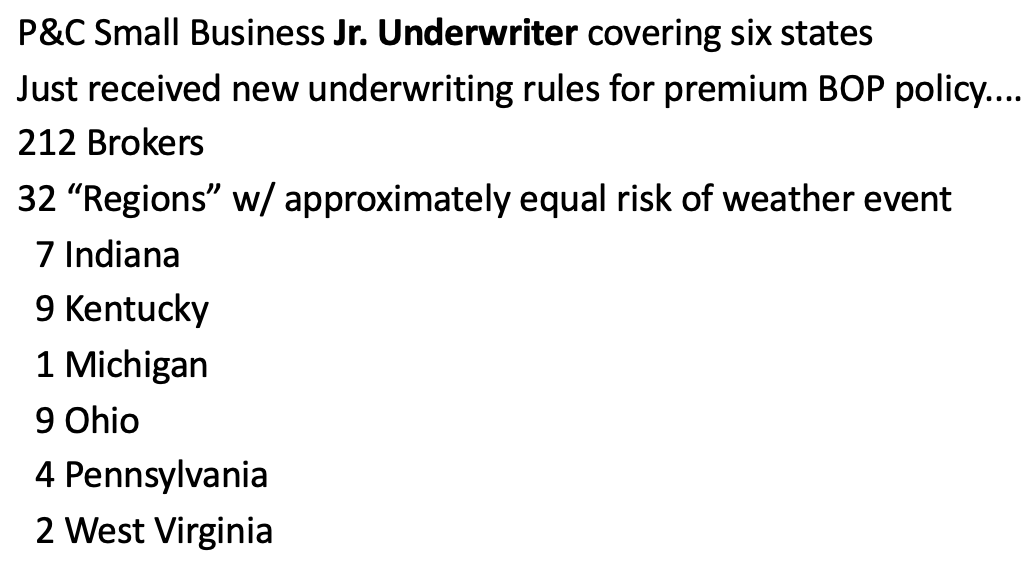

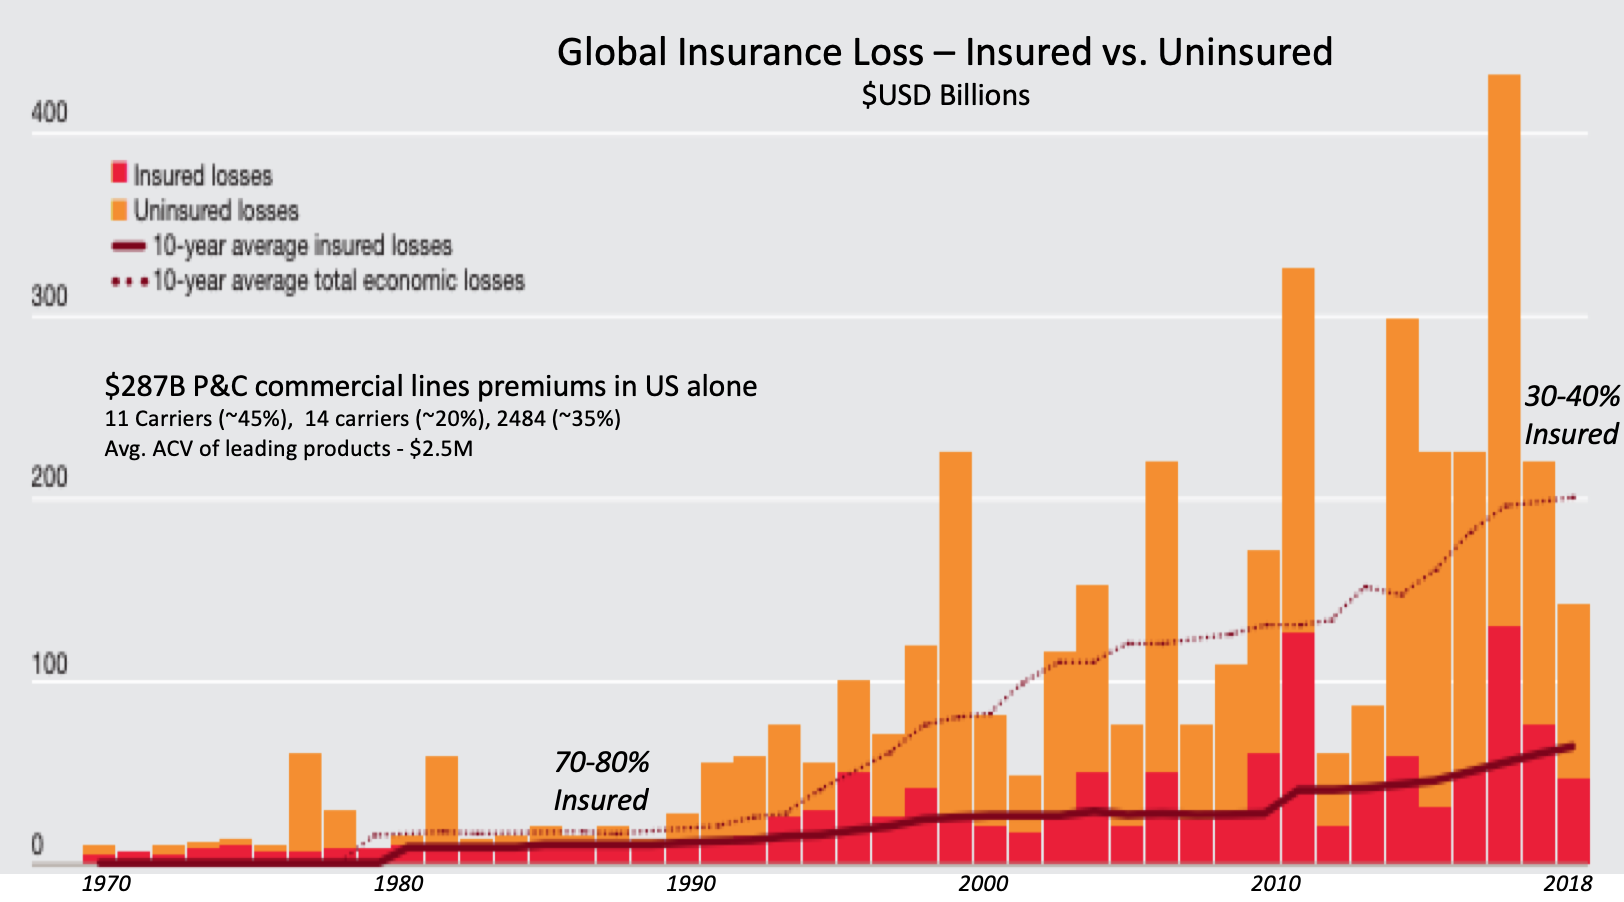